<a href="https://colab.research.google.com/github/jbsher/p4_waste_classification/blob/master/combined_waste_classification_wj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4 - Waste Classification**
Team 3: Brody Sherwood, Woojong Choi

## **Imports**

### Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop

import os
import cv2 # library for working with images in Python
import random

### Data

In [ ]:
# The following code failed to unzip the dataset. Keeping for future reference.
# reference: https://www.youtube.com/watch?v=yEXkEUqK52Q (Loading Kaggle data directly into Google Colab)

# ! pip install kaggle
# from google.colab import drive
# drive.mount('/content/drive')
# ! mkdir ~/.kaggle
# !cp /content/drive/MyDrive/general_assembly/group_project/kaggle_api ~.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download techsash/waste-classification-data
# ! unzip waste-classification-data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading Training data

In [ ]:
# The following website served as a reference to load and label the image data
# Reference: https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
# Reference: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

train_path = '/content/drive/MyDrive/general_assembly/group_project/DATASET/TRAIN'
categories = ['O', 'R']
train_data = []
train_labels = []

In [ ]:
# Loop through each category to load and preprocess data

for category in categories:
    category_directory = os.path.join(train_path, category)
    for image in os.listdir(category_directory):
        image_path = os.path.join(category_directory, image)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting to RGB for TensorFlow (OpenCV load images in BRG so needs conversion)
        img = cv2.resize(img, (128, 128))  # adjusting image size. Started with 256x256, colab memory maxed out.
        train_data.append(img)
        train_labels.append(categories.index(category)) # 0: Organic, 1: Recyclable

train_data = np.array(train_data)
train_labels = np.array(train_labels)

#### Loading Test data

In [ ]:
# The following website served as a reference to load and label the image data
# Reference: https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
# Reference: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

test_path = '/content/drive/MyDrive/general_assembly/group_project/DATASET/TEST'
categories = ['O', 'R']
test_data = []
test_labels = []

In [ ]:
# Loop through each category to load and preprocess data

for category in categories:
    category_directory = os.path.join(test_path, category)
    for image in os.listdir(category_directory):
        image_path = os.path.join(category_directory, image)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting to RGB for TensorFlow (OpenCV load images in BRG so needs conversion)
        img = cv2.resize(img, (128, 128))  # adjusting image size. adjusting image size. Started with 256x256, colab memory maxed out.
        test_data.append(img)
        test_labels.append(categories.index(category)) # 0: Organic, 1: Recyclable

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
# Saving the training and test data arrays

save_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays'

np.save(os.path.join(save_path, 'train_data.npy'), train_data)
np.save(os.path.join(save_path, 'train_labels.npy'), train_labels)
np.save(os.path.join(save_path, 'test_data.npy'), test_data)
np.save(os.path.join(save_path, 'test_labels.npy'), test_labels)

In [3]:
# Reading data

train_data_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/train_data.npy'
train_labels_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/train_labels.npy'
test_data_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/test_data.npy'
test_labels_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/test_labels.npy'

train_data = np.load(train_data_path)
train_labels = np.load(train_labels_path)
test_data = np.load(test_data_path)
test_labels = np.load(test_labels_path)

## **EDA**

In [ ]:
train_data[:1]

array([[[[223, 225, 222],
         [225, 227, 224],
         [228, 230, 227],
         ...,
         [220, 215, 212],
         [219, 214, 210],
         [218, 213, 209]],

        [[223, 225, 222],
         [225, 227, 224],
         [228, 230, 227],
         ...,
         [221, 216, 212],
         [220, 215, 211],
         [218, 213, 209]],

        [[223, 225, 222],
         [225, 227, 224],
         [228, 230, 227],
         ...,
         [222, 217, 214],
         [221, 217, 213],
         [219, 215, 211]],

        ...,

        [[127, 118,  74],
         [165, 157, 107],
         [144, 133,  81],
         ...,
         [156, 150,  83],
         [157, 150,  83],
         [159, 151,  84]],

        [[235, 215, 160],
         [236, 215, 157],
         [199, 177, 116],
         ...,
         [156, 147,  84],
         [157, 147,  85],
         [159, 148,  86]],

        [[168, 144,  87],
         [185, 161, 101],
         [156, 131,  65],
         ...,
         [155, 144,  80],
        

In [ ]:
train_data.shape

(22564, 128, 128, 3)

train:
 - 22564 images
 - 128 x 128 pixels
 - 3 channel (RGB)

In [ ]:
test_data.shape

(2513, 128, 128, 3)

test:

- 2513 images
- 128 x 128 pixels
- 3 channel (RGB)

In [ ]:
train_labels[:10], test_labels[:10]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
train_labels[:-10], test_labels[:-10]

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
train_labels.shape, test_labels.shape

((22564,), (2513,))

In [ ]:
np.unique(train_labels), np.unique(test_labels)

(array([0, 1]), array([0, 1]))

1


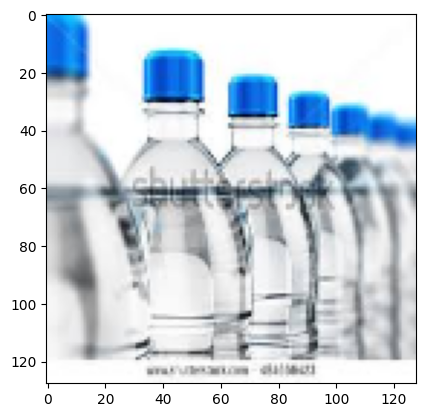

In [ ]:
# checking to see if train images are loaded properly

image_index = 22145
plt.imshow(train_data[image_index])
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/image1.jpg')
print(train_labels[image_index]);

0


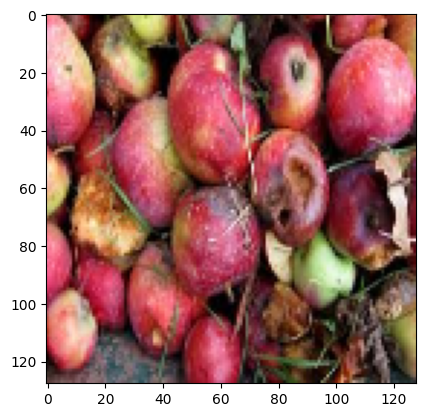

In [ ]:
# checking to see if train images are loaded properly

image_index = 3597
plt.imshow(train_data[image_index])
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/image2.jpg')
print(train_labels[image_index]);

1


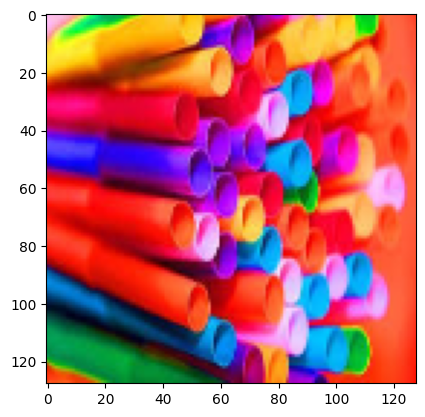

In [ ]:
# checking to see if test images are loaded properly

image_index = 2000
plt.imshow(test_data[image_index])
print(test_labels[image_index]);

0


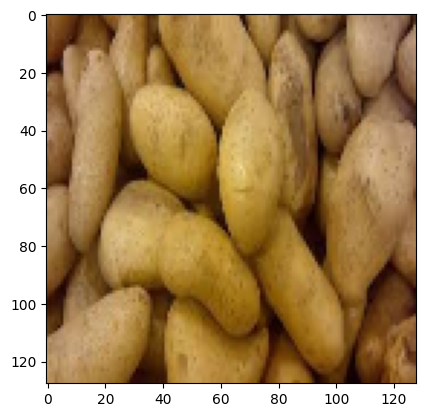

In [ ]:
# checking to see if test images are loaded properly

image_index = 359
plt.imshow(test_data[image_index])
print(test_labels[image_index]);

In [ ]:
# Define a function to display random samples

def show_random_images(data, labels, categories, num_samples, image_name):
  '''
  Input: data, labels, categories, sample count, image name for saving.
  Output: Specified number of randomly selected images with class label.
  '''
  plt.figure(figsize=(12, 5))
  for i in range(num_samples):
    index1 = random.randint(0, len(data) - 1)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(data[index1])
    plt.title(categories[labels[index1]])
    plt.axis('off')
  plt.savefig(f"/content/drive/MyDrive/general_assembly/group_project/assets/random_images_{image_name}.jpg")
  plt.show()

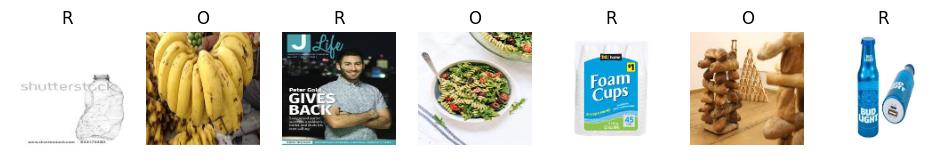

In [ ]:
show_random_images(train_data, train_labels, categories, 7, 'random1')

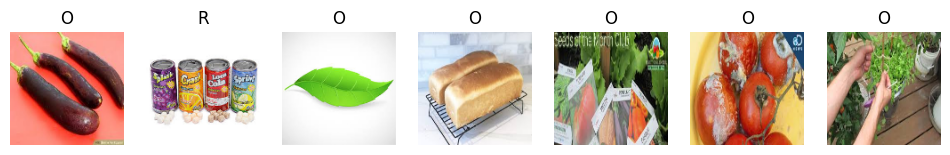

In [ ]:
show_random_images(train_data, train_labels, categories, 7, 'random2')

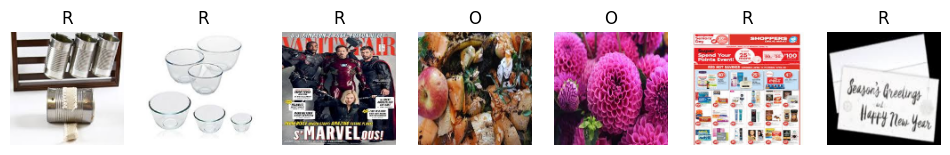

In [ ]:
show_random_images(train_data, train_labels, categories, 7, 'random3')

In [ ]:
# label distribution
# reference: https://www.tutorialspoint.com/how-to-count-the-frequency-of-unique-values-in-numpy-array#:~:text=Method%201%3A%20Using%20the%20np.&text=By%20using%20the%20np.,function%20and%20print%20the%20results.

labels, counts = np.unique(train_labels, return_counts=True)

for label, count in zip(labels, counts):
  print(f'{label}: {count}')

print(f'Organic: {counts[0]/len(train_labels)}')
print(f'Recyclable: {counts[1]/len(train_labels)}')

0: 12565
1: 9999
Organic: 0.5568604857294805
Recyclable: 0.4431395142705194


In [ ]:
# label distribution
# reference: https://www.tutorialspoint.com/how-to-count-the-frequency-of-unique-values-in-numpy-array#:~:text=Method%201%3A%20Using%20the%20np.&text=By%20using%20the%20np.,function%20and%20print%20the%20results.

labels, counts = np.unique(test_labels, return_counts=True)

for label, count in zip(labels, counts):
  print(f'{label}: {count}')

print(f'Organic: {counts[0]/len(test_labels)}')
print(f'Recyclable: {counts[1]/len(test_labels)}')

0: 1401
1: 1112
Organic: 0.5575009948269001
Recyclable: 0.44249900517309987


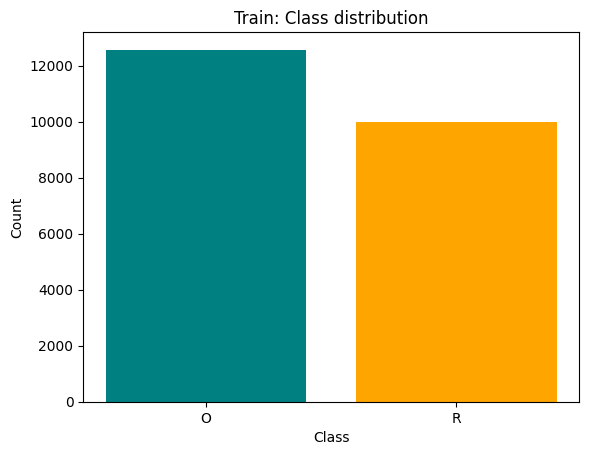

In [ ]:
# Train class distribution

labels, counts = np.unique(train_labels, return_counts=True)

plt.bar(labels, counts, color=['teal', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train: Class distribution')
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Train_Class_distribution.jpg')
plt.xticks(labels, categories);

Train:
 - Oraganic = 12565 (0.557%)
 - Recyclable = 9999 (0.443%)

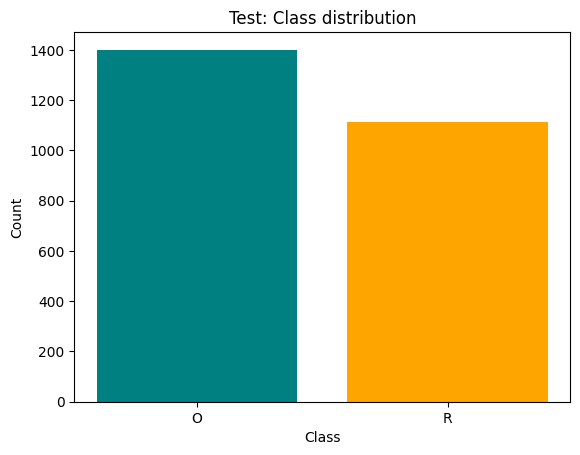

In [ ]:
# Test class distribution

labels, counts = np.unique(test_labels, return_counts=True)

plt.bar(labels, counts, color=['teal', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test: Class distribution')
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Test_Class_distribution.jpg')
plt.xticks(labels, categories);

Test:
 - Oraganic = 1401 (0.557%)
 - Recyclable = 1112 (0.442%)

Train and test have very similar class distribution

161.200417294835


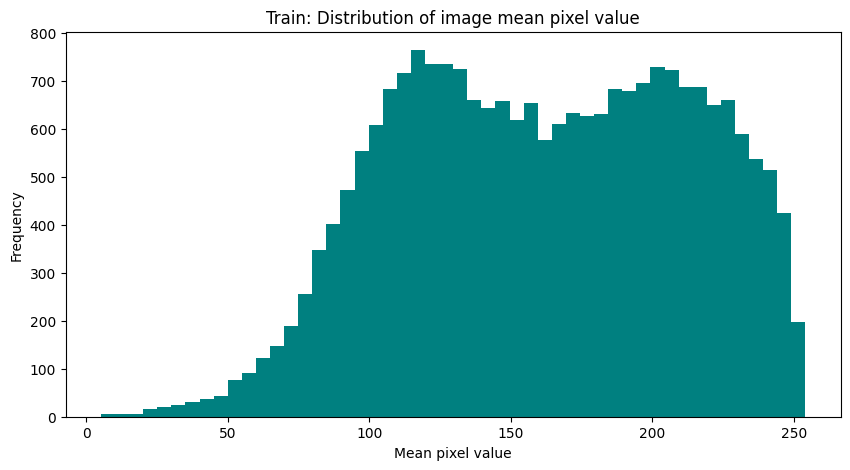

In [ ]:
# Train - check distribution of pixel color values

image_pixel_mean = [np.mean(image) for image in train_data]
print(np.mean(image_pixel_mean))

plt.figure(figsize=(10,5))
plt.hist(image_pixel_mean, bins=50, color='teal')
plt.title('Train: Distribution of image mean pixel value')
plt.xlabel('Mean pixel value')
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Train_Distribution_of_image_mean_pixel_value.jpg')
plt.ylabel('Frequency');

157.7309511212269


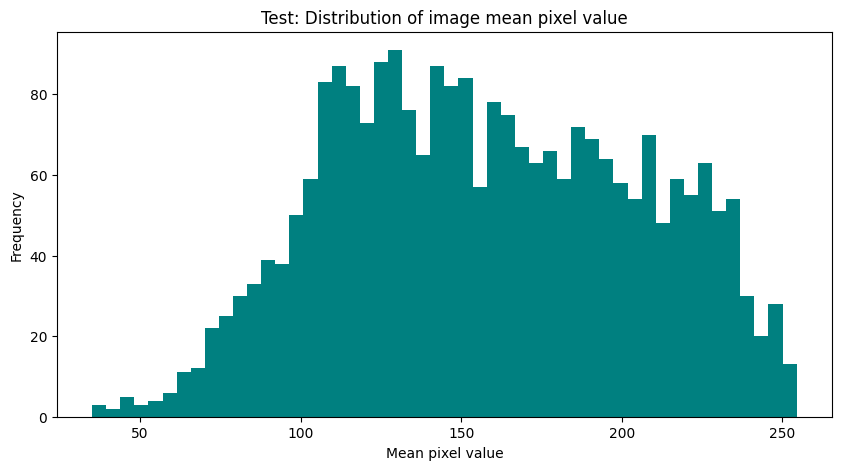

In [ ]:
# Test - check distribution of pixel color values

image_pixel_mean = [np.mean(image) for image in test_data]
print(np.mean(image_pixel_mean))

plt.figure(figsize=(10,5))
plt.hist(image_pixel_mean, bins=50, color='teal')
plt.title('Test: Distribution of image mean pixel value')
plt.xlabel('Mean pixel value')
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Test_Distribution_of_image_mean_pixel_value.jpg')
plt.ylabel('Frequency');

The average pixel intensity of train and test are pretty similar. Approximately 161 for train and 157 for test. The distribution for train exhibits a bimodal distribution. Both distribtuions have slight left skew.

Organic: 145.65
Recyclable: 180.75


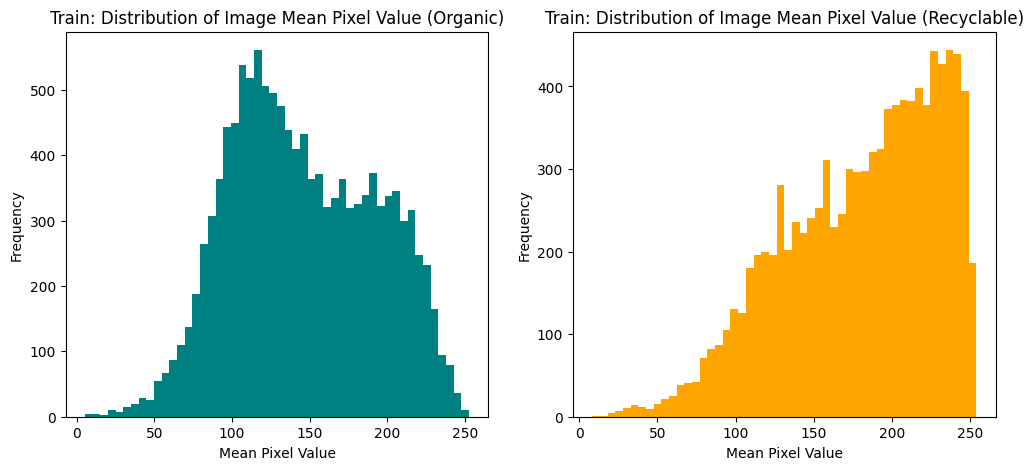

In [ ]:
# Train - check distribution of pixel color values by class

organic_samples = train_data[train_labels == 0]
recyclable_samples = train_data[train_labels == 1]

organic_image_pixel_mean = [np.mean(image) for image in organic_samples]
print(f'Organic: {round(np.mean(organic_image_pixel_mean),2)}')

recyclable_image_pixel_mean = [np.mean(image) for image in recyclable_samples]
print(f'Recyclable: {round(np.mean(recyclable_image_pixel_mean),2)}')

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist(organic_image_pixel_mean, bins=50, color='teal')
plt.title('Train: Distribution of Image Mean Pixel Value (Organic)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(recyclable_image_pixel_mean, bins=50, color='orange')
plt.title('Train: Distribution of Image Mean Pixel Value (Recyclable)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Train_Distribution_of_image_mean_pixel_value_by_class.jpg')
plt.show()

Organic: 138.93
Recyclable: 181.42


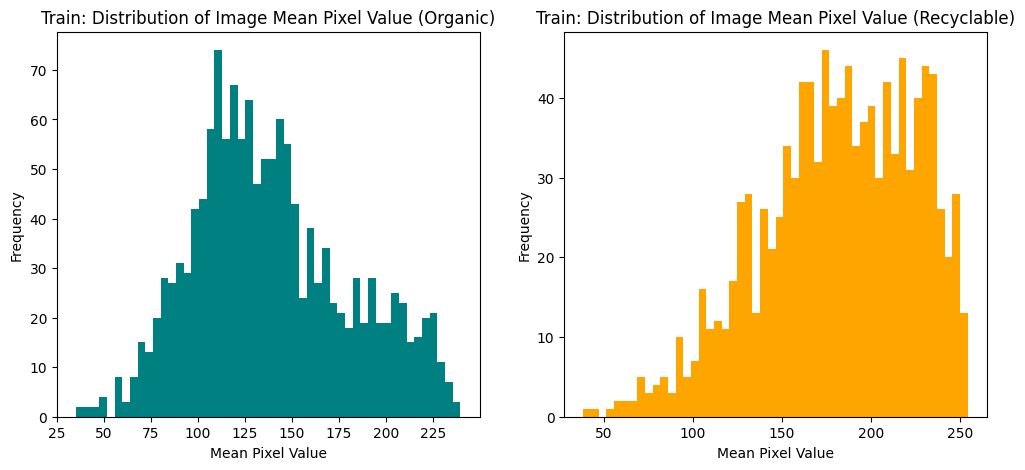

In [ ]:
# Test - check distribution of pixel color values by class

organic_samples = test_data[test_labels == 0]
recyclable_samples = test_data[test_labels == 1]

organic_image_pixel_mean = [np.mean(image) for image in organic_samples]
print(f'Organic: {round(np.mean(organic_image_pixel_mean),2)}')

recyclable_image_pixel_mean = [np.mean(image) for image in recyclable_samples]
print(f'Recyclable: {round(np.mean(recyclable_image_pixel_mean),2)}')

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist(organic_image_pixel_mean, bins=50, color='teal')
plt.title('Test: Distribution of Image Mean Pixel Value (Organic)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(recyclable_image_pixel_mean, bins=50, color='orange')
plt.title('Test: Distribution of Image Mean Pixel Value (Recyclable)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Test_Distribution_of_image_mean_pixel_value_by_class.jpg')
plt.show()

The pixel intensity distribution for organic and recyclable waste look very different. The mean pixel value is a lot higher for recyclable wastes.

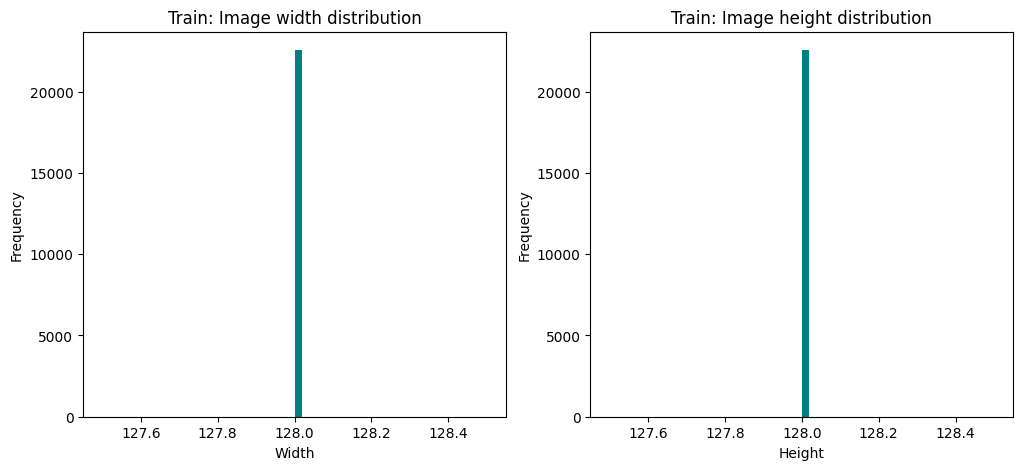

In [ ]:
# Train: Checking to make sure the image shapes are consistent as specified when loading the data

image_widths = [image.shape[1] for image in train_data]
image_heights = [image.shape[0] for image in train_data]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(image_widths, bins=50, color='teal')
plt.title('Train: Image width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(image_heights, bins=50, color='teal')
plt.title('Train: Image height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Train_Image_height_distribution.jpg')
plt.show()

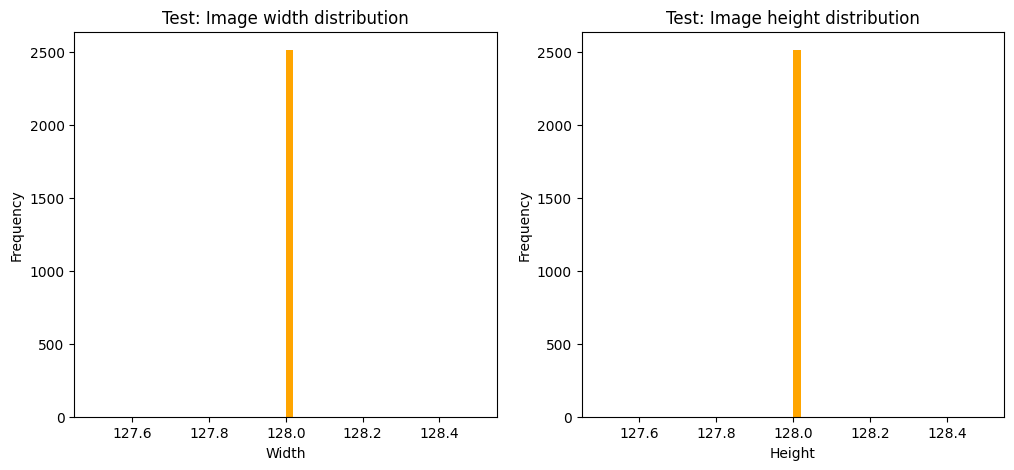

In [ ]:
# Test: Checking to make sure the image shapes are consistent as specified when loading the data

image_widths = [image.shape[1] for image in test_data]
image_heights = [image.shape[0] for image in test_data]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(image_widths, bins=50, color='orange')
plt.title('Test: Image width distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(image_heights, bins=50, color='orange')
plt.title('Test: Image height distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/Test_Image_height_distribution.jpg')
plt.show()

##### Indexing train_data to better understand the color channels

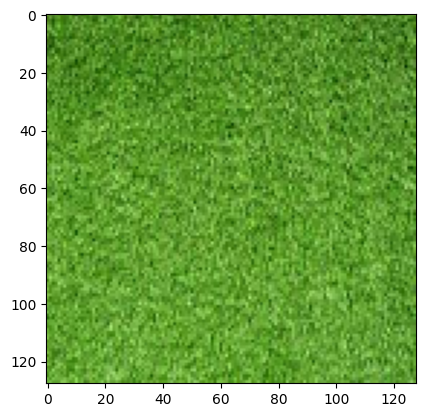

In [ ]:
plt.imshow(train_data[359]);

In [ ]:
# 128 x 128 pixels, 3 channels

train_data[359].shape

(128, 128, 3)

In [ ]:
# 128 rows (vertical pixels)

len(train_data[359])

128

In [ ]:
# 1st column 128 rows (vertical pixels)

len(train_data[359][0])

128

In [ ]:
# 2nd column 128 rows (vertical pixels)

len(train_data[359][1])

128

In [ ]:
# 1 pixel

train_data[359][0,0]

array([125, 172,  75], dtype=uint8)

In [ ]:
# 1st column first 5 rows (vertical pixels)

train_data[359][0][:5]

array([[125, 172,  75],
       [ 83, 133,  41],
       [ 83, 137,  45],
       [ 93, 152,  48],
       [ 82, 144,  30]], dtype=uint8)

In [ ]:
# extracting RGBs - Red

train_data[359][:,:,0].ravel()

array([125,  83,  83, ..., 113, 145, 105], dtype=uint8)

In [ ]:
np.mean(train_data[359][:,:,0].ravel())

92.012451171875

In [ ]:
# extracting RGBs - Green

train_data[359][:,:,1].ravel()

array([172, 133, 137, ..., 173, 205, 163], dtype=uint8)

In [ ]:
np.mean(train_data[359][:,:,1].ravel())

153.21173095703125

In [ ]:
# extracting RGB - Blue

# [98, 70, 42, ..., 83, 68, 59]

train_data[359][:,:,2].ravel()

array([ 75,  41,  45, ...,  73, 104,  60], dtype=uint8)

In [ ]:
np.mean(train_data[359][:,:,2].ravel())

44.89556884765625

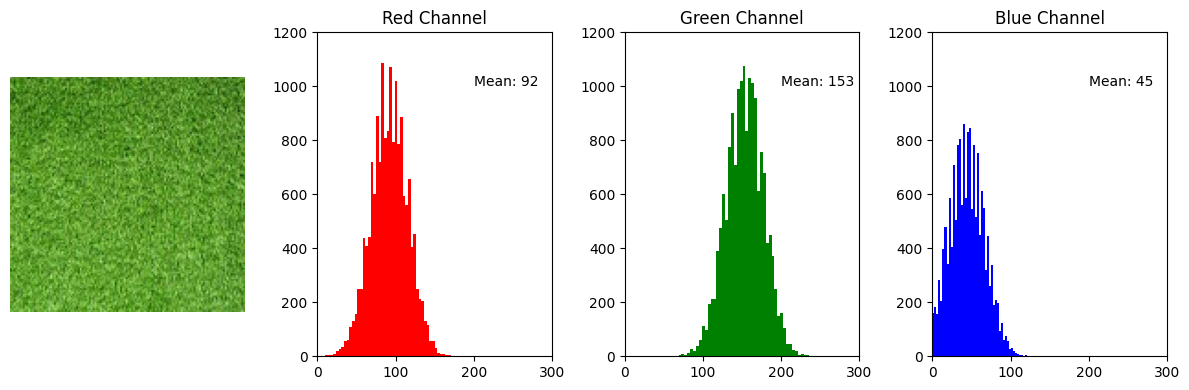

In [ ]:
# Extract color channel distribtuions for an image

sample_image = train_data[359]
red_channel = sample_image[:, :, 0]
green_channel = sample_image[:, :, 1]
blue_channel = sample_image[:, :, 2]

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.hist(red_channel.ravel(), bins=50, color='red')
plt.title('Red Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(red_channel))}', color='black', fontsize=10)

plt.subplot(1, 4, 3)
plt.hist(green_channel.ravel(), bins=50, color='green')
plt.title('Green Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(green_channel))}', color='black', fontsize=10)

plt.subplot(1, 4, 4)
plt.hist(blue_channel.ravel(), bins=50, color='blue')
plt.title('Blue Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(blue_channel))}', color='black', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/color_channel_distribution_grass.jpg')
plt.show()

We can see that Green Channel is much higher for the patch of grass (mostly green)



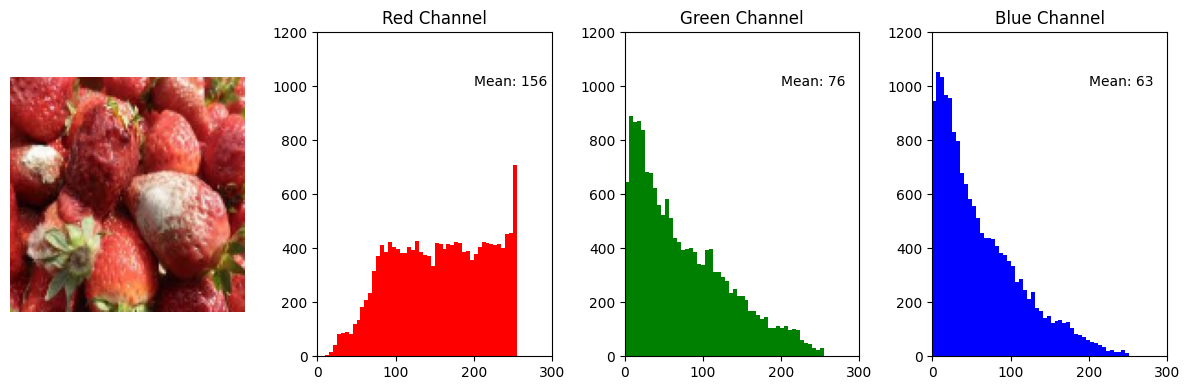

In [ ]:
# Extract color channel distribtuions for an image

sample_image = train_data[12000]
red_channel = sample_image[:, :, 0]
green_channel = sample_image[:, :, 1]
blue_channel = sample_image[:, :, 2]

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.hist(red_channel.ravel(), bins=50, color='red')
plt.title('Red Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(red_channel))}', color='black', fontsize=10)

plt.subplot(1, 4, 3)
plt.hist(green_channel.ravel(), bins=50, color='green')
plt.title('Green Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(green_channel))}', color='black', fontsize=10)

plt.subplot(1, 4, 4)
plt.hist(blue_channel.ravel(), bins=50, color='blue')
plt.title('Blue Channel')
plt.xlim(0, 300)
plt.ylim(0, 1200)
plt.text(200, 1000, f'Mean: {round(np.mean(blue_channel))}', color='black', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/color_channel_distribution_strawberry.jpg')
plt.show()

Red Channel Mean: 167
Green Channel Mean: 150
Blue Channel Mean: 120


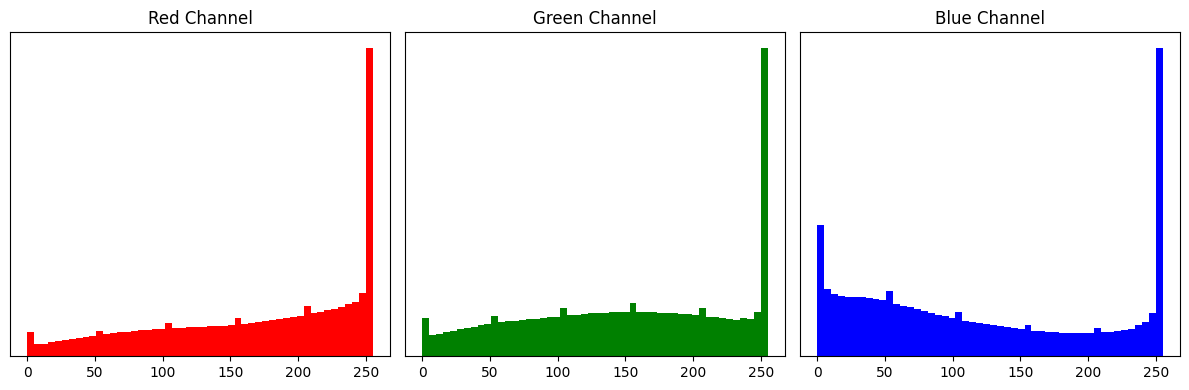

In [ ]:
# Extract color channel distribtuions by class - Organic

# # reference: https://stackoverflow.com/questions/33711985/flattening-a-list-of-numpy-arrays
organics = train_data[train_labels == 0]
organic_red_channel = [image[:, :, 0] for image in organics]
organic_red_channel = np.concatenate(organic_red_channel)
organic_green_channel = [image[:, :, 1] for image in organics]
organic_green_channel = np.concatenate(organic_green_channel)
organic_blue_channel = [image[:, :, 2] for image in organics]
organic_blue_channel = np.concatenate(organic_blue_channel)

plt.figure(figsize=(12, 4))

print(f'Red Channel Mean: {round(np.mean(organic_red_channel))}')
print(f'Green Channel Mean: {round(np.mean(organic_green_channel))}')
print(f'Blue Channel Mean: {round(np.mean(organic_blue_channel))}')

plt.subplot(1, 3, 1)
plt.hist(organic_red_channel.ravel(), bins=50, color='red')
plt.title('Red Channel')
plt.yticks([])

plt.subplot(1, 3, 2)
plt.hist(organic_green_channel.ravel(), bins=50, color='green')
plt.title('Green Channel')
plt.yticks([])

plt.subplot(1, 3, 3)
plt.hist(organic_blue_channel.ravel(), bins=50, color='blue')
plt.title('Blue Channel')
plt.yticks([])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/color_channel_distribution_organic.jpg')
plt.show()

For organic waste, the most predominant color is Red followed by Green.

Red Channel Mean: 186
Green Channel Mean: 181
Blue Channel Mean: 175


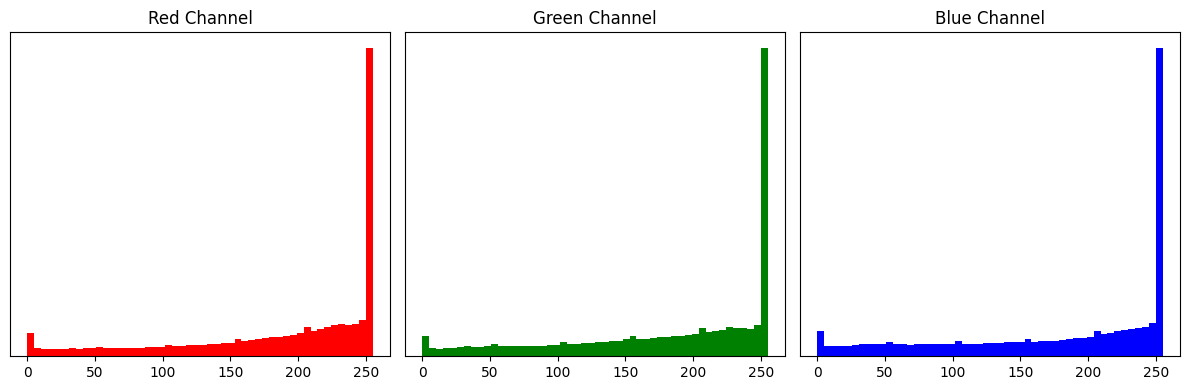

In [ ]:
# Extract color channel distribtuions by class - Recyclable

# # reference: https://stackoverflow.com/questions/33711985/flattening-a-list-of-numpy-arrays
organics = train_data[train_labels == 1]
organic_red_channel = [image[:, :, 0] for image in organics]
organic_red_channel = np.concatenate(organic_red_channel)
organic_green_channel = [image[:, :, 1] for image in organics]
organic_green_channel = np.concatenate(organic_green_channel)
organic_blue_channel = [image[:, :, 2] for image in organics]
organic_blue_channel = np.concatenate(organic_blue_channel)

plt.figure(figsize=(12, 4))

print(f'Red Channel Mean: {round(np.mean(organic_red_channel))}')
print(f'Green Channel Mean: {round(np.mean(organic_green_channel))}')
print(f'Blue Channel Mean: {round(np.mean(organic_blue_channel))}')

plt.subplot(1, 3, 1)
plt.hist(organic_red_channel.ravel(), bins=50, color='red')
plt.title('Red Channel')
plt.yticks([])

plt.subplot(1, 3, 2)
plt.hist(organic_green_channel.ravel(), bins=50, color='green')
plt.title('Green Channel')
plt.yticks([])

plt.subplot(1, 3, 3)
plt.hist(organic_blue_channel.ravel(), bins=50, color='blue')
plt.title('Blue Channel')
plt.yticks([])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/color_channel_distribution_recyclable.jpg')
plt.show()

For recyclable waste, the 3 colors are used pretty evenly, but similar to organic waste, Red is the most predominant color followed by Green.

## **Data Preprocessing**

In [6]:
# shape before train_val split

train_data.shape, train_labels.shape

((22564, 128, 128, 3), (22564,))

In [8]:
# normalize data

train_data = train_data / 255
test_data_norm = test_data / 255

In [ ]:
# train, validation split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.20, random_state=42, stratify=train_labels)

In [7]:
# shape after train, validation split

X_train.shape, y_train.shape

((18051, 128, 128, 3), (18051,))

In [ ]:
# shape after train, validation split

X_val.shape, y_val.shape

((4513, 128, 128, 3), (4513,))

In [12]:
# saving X_train, X_val, y_train, y_val
# train_test_split' caused Colab to crash due to insufficient memory. Saving the files for future use.

save_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays'

np.save(os.path.join(save_path, 'X_train.npy'), X_train)
np.save(os.path.join(save_path, 'X_val.npy'), X_val)
np.save(os.path.join(save_path, 'y_train.npy'), y_train)
np.save(os.path.join(save_path, 'y_val.npy'), y_val)
np.save(os.path.join(save_path, 'test_data_norm.npy'), test_data_norm)

In [5]:
# Reading data

X_train_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/X_train.npy'
X_val_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/X_val.npy'
y_train_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/y_train.npy'
y_val_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/y_val.npy'

X_train = np.load(X_train_path)
X_val = np.load(X_val_path)
y_train = np.load(y_train_path)
y_val = np.load(y_val_path)

test_data_norm_path = '/content/drive/MyDrive/general_assembly/group_project/train_test_data_arrays/test_data_norm.npy'
test_data_norm = np.load(test_data_norm_path)

## **Modeling**

#### Baseline accuracy

In [5]:
labels, counts = np.unique(y_train, return_counts=True)

for label, count in zip(labels, counts):
  print(f'{label}: {count}')

print(f'Organic: {round(counts[0]/len(y_train) * 100, 2)}%')
print(f'Recyclable: {round(counts[1]/len(y_train) * 100, 2)}%')

0: 10052
1: 7999
Organic: 55.69%
Recyclable: 44.31%


#### Model 1

In [ ]:
model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model1.add(MaxPooling2D(2))

model1.add(Conv2D(64, 3, activation='relu'))
model1.add(MaxPooling2D(2))

model1.add(Flatten())

model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history1 = model1.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 10,
                      batch_size = 512)

Epoch 1/10
36/36 [==============================] - 17s 293ms/step - loss: 0.6837 - acc: 0.5684 - val_loss: 0.6663 - val_acc: 0.5568
Epoch 2/10
36/36 [==============================] - 6s 180ms/step - loss: 0.6495 - acc: 0.6297 - val_loss: 0.6164 - val_acc: 0.6918
Epoch 3/10
36/36 [==============================] - 6s 180ms/step - loss: 0.6073 - acc: 0.6754 - val_loss: 0.5755 - val_acc: 0.7040
Epoch 4/10
36/36 [==============================] - 6s 181ms/step - loss: 0.5944 - acc: 0.6850 - val_loss: 0.5511 - val_acc: 0.7232
Epoch 5/10
36/36 [==============================] - 7s 182ms/step - loss: 0.5807 - acc: 0.6952 - val_loss: 0.5407 - val_acc: 0.7294
Epoch 6/10
36/36 [==============================] - 7s 182ms/step - loss: 0.5717 - acc: 0.7014 - val_loss: 0.5397 - val_acc: 0.7288
Epoch 7/10
36/36 [==============================] - 7s 184ms/step - loss: 0.5618 - acc: 0.7133 - val_loss: 0.5535 - val_acc: 0.7204
Epoch 8/10
36/36 [==============================] - 7s 184ms/step - loss: 0

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

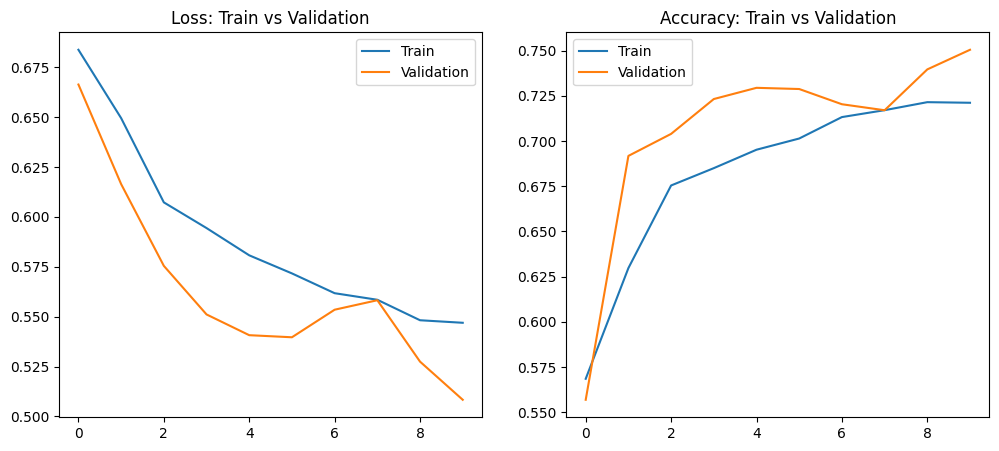

In [ ]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history1.history['loss'], label='Train')
ax1.plot(history1.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history1.history['acc'], label='Train')
ax2.plot(history1.history['val_acc'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model1_loss_accuracy.jpg');

In [ ]:
history1.history['acc'][-1], history1.history['val_acc'][-1]

(0.7211788892745972, 0.7504985332489014)

The first model outperformed the baseline significantly. There's a minor sign of underfitting. There is room for improvement in the model's performance.

#### Model 2

In [ ]:
# Model1 + Conv2D layer + epochs = 20

model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model2.add(MaxPooling2D(2))

model2.add(Conv2D(64, 3, activation='relu'))
model2.add(MaxPooling2D(2))

model2.add(Conv2D(128, 3, activation='relu'))
model2.add(MaxPooling2D(2))

model2.add(Flatten())

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history2 = model2.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 20,
                      batch_size = 512)

Epoch 1/20
36/36 [==============================] - 13s 297ms/step - loss: 0.6882 - acc: 0.5556 - val_loss: 0.6865 - val_acc: 0.5568
Epoch 2/20
36/36 [==============================] - 8s 228ms/step - loss: 0.6869 - acc: 0.5569 - val_loss: 0.6866 - val_acc: 0.5568
Epoch 3/20
36/36 [==============================] - 8s 228ms/step - loss: 0.6792 - acc: 0.5637 - val_loss: 0.6498 - val_acc: 0.5641
Epoch 4/20
36/36 [==============================] - 8s 228ms/step - loss: 0.6477 - acc: 0.6282 - val_loss: 0.6009 - val_acc: 0.7075
Epoch 5/20
36/36 [==============================] - 8s 226ms/step - loss: 0.6171 - acc: 0.6667 - val_loss: 0.5830 - val_acc: 0.7031
Epoch 6/20
36/36 [==============================] - 8s 224ms/step - loss: 0.6034 - acc: 0.6792 - val_loss: 0.5618 - val_acc: 0.7210
Epoch 7/20
36/36 [==============================] - 8s 223ms/step - loss: 0.5834 - acc: 0.6979 - val_loss: 0.5748 - val_acc: 0.7055
Epoch 8/20
36/36 [==============================] - 8s 222ms/step - loss: 0

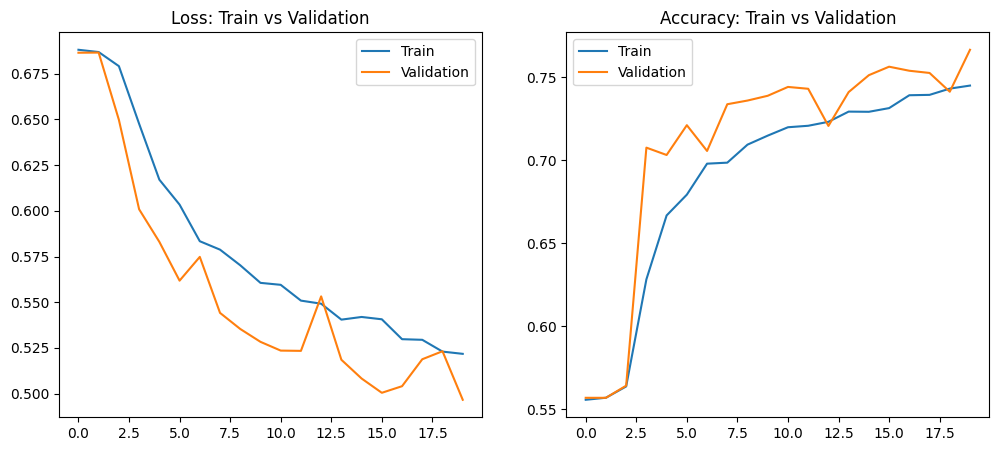

In [ ]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history2.history['loss'], label='Train')
ax1.plot(history2.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history2.history['acc'], label='Train')
ax2.plot(history2.history['val_acc'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model2_loss_accuracy.jpg');

In [ ]:
history2.history['acc'][-1], history2.history['val_acc'][-1]

(0.744889497756958, 0.7664524912834167)

Adding more layers did not substantially enhance the model's performance, and underfitting persists.

#### Model 3

In [ ]:
# Model2 + Dense layer(10) & optimizer='adam'

model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model3.add(MaxPooling2D(2))

model3.add(Conv2D(64, 3, activation='relu'))
model3.add(MaxPooling2D(2))

model3.add(Conv2D(128, 3, activation='relu'))
model3.add(MaxPooling2D(2))

model3.add(Conv2D(256, 3, activation='relu'))
model3.add(MaxPooling2D(2))

model3.add(Flatten())

model3.add(Dense(10, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history3 = model3.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 20,
                      batch_size = 512)

Epoch 1/20
36/36 [==============================] - 23s 368ms/step - loss: 0.6868 - acc: 0.5569 - val_loss: 0.6723 - val_acc: 0.5568
Epoch 2/20
36/36 [==============================] - 8s 232ms/step - loss: 0.6337 - acc: 0.6483 - val_loss: 0.6103 - val_acc: 0.7124
Epoch 3/20
36/36 [==============================] - 8s 233ms/step - loss: 0.6050 - acc: 0.7259 - val_loss: 0.6124 - val_acc: 0.7270
Epoch 4/20
36/36 [==============================] - 8s 235ms/step - loss: 0.5909 - acc: 0.7369 - val_loss: 0.5661 - val_acc: 0.7607
Epoch 5/20
36/36 [==============================] - 9s 238ms/step - loss: 0.5685 - acc: 0.7540 - val_loss: 0.5759 - val_acc: 0.7476
Epoch 6/20
36/36 [==============================] - 9s 238ms/step - loss: 0.5654 - acc: 0.7586 - val_loss: 0.5758 - val_acc: 0.7432
Epoch 7/20
36/36 [==============================] - 9s 240ms/step - loss: 0.5626 - acc: 0.7595 - val_loss: 0.5349 - val_acc: 0.7837
Epoch 8/20
36/36 [==============================] - 9s 243ms/step - loss: 0

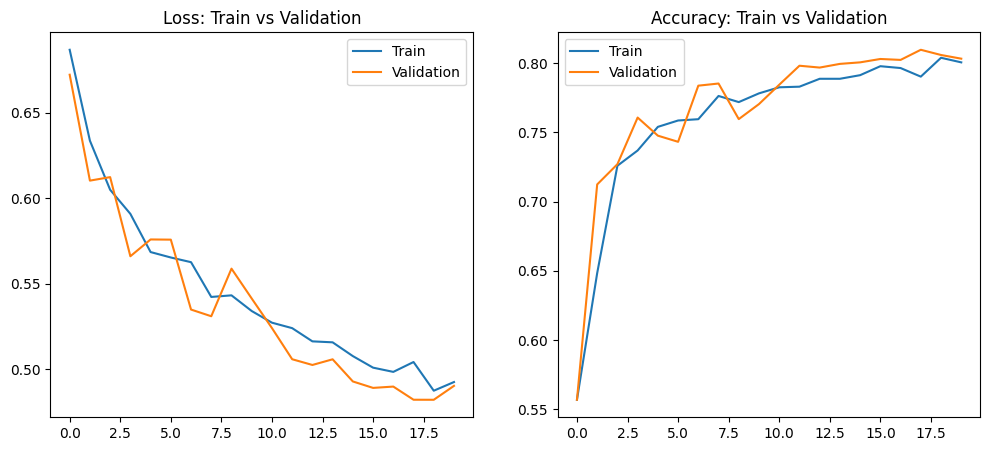

In [ ]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history3.history['loss'], label='Train')
ax1.plot(history3.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history3.history['acc'], label='Train')
ax2.plot(history3.history['val_acc'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model3_loss_accuracy.jpg');

In [ ]:
history3.history['acc'][-1], history3.history['val_acc'][-1]

(0.8005650639533997, 0.8032351136207581)

Performance increased significnatly for the third iteration. There is not sign of under/overfitting.

#### Model 4

In [ ]:
# Model3 & Dense layer(32) & epochs = 30

model4 = Sequential()

model4.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model4.add(MaxPooling2D(2))

model4.add(Conv2D(64, 3, activation='relu'))
model4.add(MaxPooling2D(2))

model4.add(Conv2D(128, 3, activation='relu'))
model4.add(MaxPooling2D(2))

model4.add(Conv2D(256, 3, activation='relu'))
model4.add(MaxPooling2D(2))

model4.add(Flatten())

model4.add(Dense(32, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history4 = model4.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 30,
                      batch_size = 512)

Epoch 1/30
36/36 [==============================] - 22s 361ms/step - loss: 0.6729 - acc: 0.5722 - val_loss: 0.6451 - val_acc: 0.7177
Epoch 2/30
36/36 [==============================] - 8s 230ms/step - loss: 0.5838 - acc: 0.7223 - val_loss: 0.5144 - val_acc: 0.7565
Epoch 3/30
36/36 [==============================] - 8s 230ms/step - loss: 0.5168 - acc: 0.7477 - val_loss: 0.4815 - val_acc: 0.7662
Epoch 4/30
36/36 [==============================] - 8s 231ms/step - loss: 0.4809 - acc: 0.7725 - val_loss: 0.4954 - val_acc: 0.7636
Epoch 5/30
36/36 [==============================] - 8s 233ms/step - loss: 0.4907 - acc: 0.7669 - val_loss: 0.4807 - val_acc: 0.7667
Epoch 6/30
36/36 [==============================] - 8s 233ms/step - loss: 0.4674 - acc: 0.7784 - val_loss: 0.4853 - val_acc: 0.7682
Epoch 7/30
36/36 [==============================] - 8s 236ms/step - loss: 0.4645 - acc: 0.7826 - val_loss: 0.4352 - val_acc: 0.7986
Epoch 8/30
36/36 [==============================] - 9s 237ms/step - loss: 0

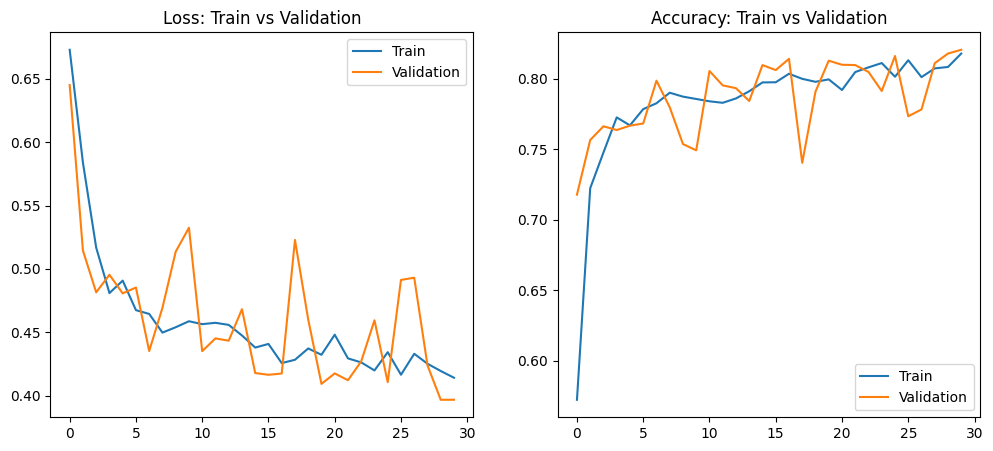

In [ ]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history4.history['loss'], label='Train')
ax1.plot(history4.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history4.history['acc'], label='Train')
ax2.plot(history4.history['val_acc'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model4_loss_accuracy.jpg');

In [ ]:
history4.history['acc'][-1], history4.history['val_acc'][-1]

(0.8178493976593018, 0.8205184936523438)

Changing the Dense layer to 32 and increasing the epochs to 30 improved the model performance slightly.

#### Model 5

In [7]:
model5 = Sequential()

# Define the data augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=45,       # Rotate the image by up to 40 degrees
    width_shift_range=0.15,  # Shift the image horizontally by up to 15% of the width
    height_shift_range=0.15, # Shift the image vertically by up to 15% of the height
    shear_range=0.1,         # Shear transformation (shear angle of 10 degrees.)
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Allow random horizontal flip
    fill_mode='nearest'      # Fill in any pixels that might be lost during transformation
)

# First convolutional layer
model5.add(Conv2D(64, 3, activation='relu', input_shape=X_train[0].shape))

# Second convolutional layer
model5.add(Conv2D(128, 3, activation='relu'))
model5.add(MaxPooling2D(2))
model5.add(Dropout(0.2))

# Third convolutional layer
model5.add(Conv2D(128, 3, activation='relu'))
model5.add(Dropout(0.15))
model5.add(MaxPooling2D(2))

# Fourth convolutional layer
model5.add(Conv2D(256, 3, activation='relu'))
model5.add(Dropout(0.15))

# Fifth convolutional layer
model5.add(Conv2D(128, 3, activation='relu'))

# Fully connected layers
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(64, activation='relu'))

# Output layer
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping callback
es = EarlyStopping(monitor='val_loss', patience=5)

# Fit Augmentation
datagen.fit(X_train)


# Create variable for batch size
batch_size = 64

# Model training with data augmentation
history5 = model5.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                      steps_per_epoch=len(X_train) / batch_size,
                      epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=[es],
                      verbose = 1)

Epoch 1/50
282/282 [==============================] - 80s 255ms/step - loss: 0.4860 - accuracy: 0.7784 - val_loss: 0.4253 - val_accuracy: 0.8145
Epoch 2/50
282/282 [==============================] - 69s 243ms/step - loss: 0.4225 - accuracy: 0.8132 - val_loss: 0.4010 - val_accuracy: 0.8218
Epoch 3/50
282/282 [==============================] - 68s 241ms/step - loss: 0.3982 - accuracy: 0.8264 - val_loss: 0.3884 - val_accuracy: 0.8385
Epoch 4/50
282/282 [==============================] - 68s 242ms/step - loss: 0.3881 - accuracy: 0.8267 - val_loss: 0.3701 - val_accuracy: 0.8462
Epoch 5/50
282/282 [==============================] - 69s 243ms/step - loss: 0.3702 - accuracy: 0.8405 - val_loss: 0.3720 - val_accuracy: 0.8467
Epoch 6/50
282/282 [==============================] - 69s 245ms/step - loss: 0.3581 - accuracy: 0.8507 - val_loss: 0.4276 - val_accuracy: 0.8086
Epoch 7/50
282/282 [==============================] - 68s 241ms/step - loss: 0.3521 - accuracy: 0.8488 - val_loss: 0.3512 - val_ac

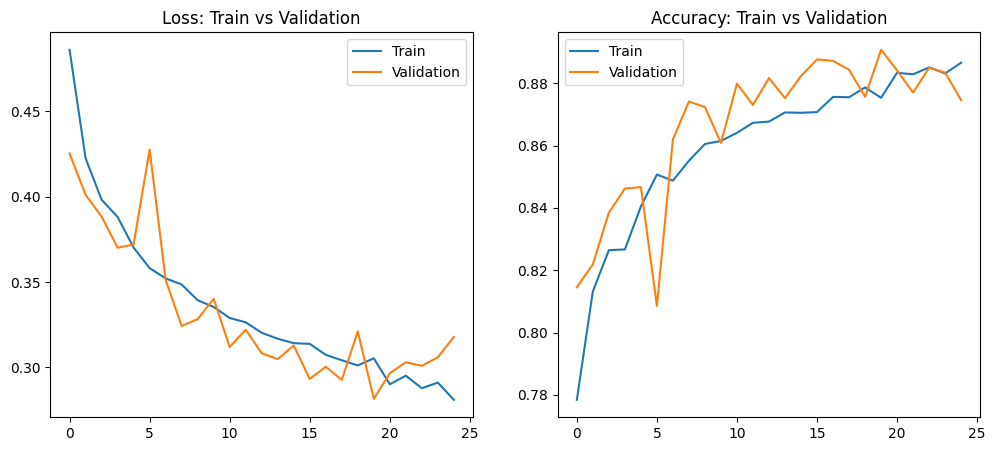

In [8]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history5.history['loss'], label='Train')
ax1.plot(history5.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history5.history['accuracy'], label='Train')
ax2.plot(history5.history['val_accuracy'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model5_loss_accuracy.jpg');

In [9]:
history5.history['accuracy'][-1], history5.history['val_accuracy'][-1]

(0.886599063873291, 0.8745845556259155)

In [10]:
# saving model

model5.save('/content/drive/MyDrive/general_assembly/group_project/models/model5.h5')
#model5 = load_model('model5.h5')

#### Model 6: VGG-16
 - Reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/#h-examples-of-pre-trained-models-for-image-classification

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=45,       # Rotate the image by up to 40 degrees
    width_shift_range=0.15,  # Shift the image horizontally by up to 15% of the width
    height_shift_range=0.15, # Shift the image vertically by up to 15% of the height
    shear_range=0.1,         # Shear transformation (shear angle of 10 degrees.)
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Allow random horizontal flip
    fill_mode='nearest'      # Fill in any pixels that might be lost during transformation
)

batch_size = 64

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

In [18]:
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

model6 = Sequential()
model6.add(base_model)
model6.add(Flatten())
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(optimizer=Adam(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['acc'])

history6 = model6.fit(train_generator,
                      steps_per_epoch=len(X_train) // batch_size, # floor division to make sure result is integer
                      epochs=10,
                      validation_data=val_generator,
                      validation_steps=len(X_val) // batch_size) # floor division to make sure result is integer

Epoch 1/10
282/282 [==============================] - 81s 268ms/step - loss: 0.6023 - acc: 0.6952 - val_loss: 0.4715 - val_acc: 0.8054
Epoch 2/10
282/282 [==============================] - 75s 266ms/step - loss: 0.4387 - acc: 0.8103 - val_loss: 0.3601 - val_acc: 0.8549
Epoch 3/10
282/282 [==============================] - 76s 267ms/step - loss: 0.4158 - acc: 0.8195 - val_loss: 0.3747 - val_acc: 0.8444
Epoch 4/10
282/282 [==============================] - 76s 270ms/step - loss: 0.3620 - acc: 0.8509 - val_loss: 0.3221 - val_acc: 0.8732
Epoch 5/10
282/282 [==============================] - 76s 270ms/step - loss: 0.3456 - acc: 0.8613 - val_loss: 0.3145 - val_acc: 0.8817
Epoch 6/10
282/282 [==============================] - 76s 269ms/step - loss: 0.3387 - acc: 0.8616 - val_loss: 0.3006 - val_acc: 0.8768
Epoch 7/10
282/282 [==============================] - 76s 270ms/step - loss: 0.3256 - acc: 0.8690 - val_loss: 0.3048 - val_acc: 0.8853
Epoch 8/10
282/282 [==============================] - 7

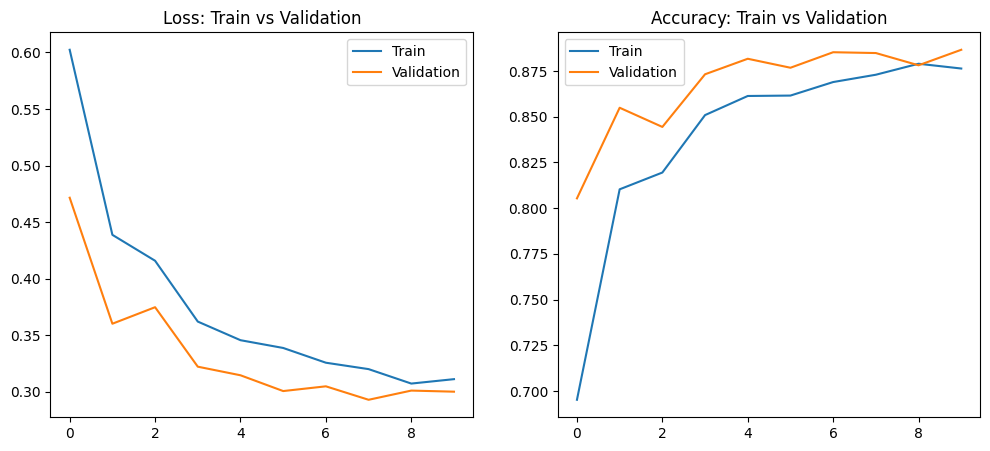

In [20]:
# Plotting loss and accruacy

plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(history6.history['loss'], label='Train')
ax1.plot(history6.history['val_loss'], label='Validation')
ax1.set_title('Loss: Train vs Validation')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(history6.history['acc'], label='Train')
ax2.plot(history6.history['val_acc'], label='Validation')
ax2.set_title('Accuracy: Train vs Validation')
ax2.legend()

plt.savefig('/content/drive/MyDrive/general_assembly/group_project/assets/model6_loss_accuracy.jpg');

In [22]:
history6.history['acc'][-1], history6.history['val_acc'][-1]

(0.8763551712036133, 0.8866071701049805)

In [23]:
# saving model

model6.save('/content/drive/MyDrive/general_assembly/group_project/models/model6.h5')
#model6 = load_model('model6.h5')